# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-06-15 14:07:06,096] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import time
env.reset()
rewards = []
for _ in range(100):
    time.sleep(0.1)
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()


In [4]:
env.close()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [3]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [4]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [5]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 250                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 128              # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [7]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state
        
print(state.shape)

(4,)


## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [8]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, state.shape[0]))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 4.0 Training loss: 1.0650 Explore P: 0.9996
Episode: 2 Total reward: 14.0 Training loss: 1.1711 Explore P: 0.9982
Episode: 3 Total reward: 11.0 Training loss: 1.2435 Explore P: 0.9971
Episode: 4 Total reward: 15.0 Training loss: 1.2809 Explore P: 0.9957
Episode: 5 Total reward: 132.0 Training loss: 7.9986 Explore P: 0.9827
Episode: 6 Total reward: 18.0 Training loss: 2.8944 Explore P: 0.9810
Episode: 7 Total reward: 30.0 Training loss: 4.8079 Explore P: 0.9781
Episode: 8 Total reward: 11.0 Training loss: 12.3468 Explore P: 0.9770
Episode: 9 Total reward: 39.0 Training loss: 12.7922 Explore P: 0.9732
Episode: 10 Total reward: 15.0 Training loss: 18.3388 Explore P: 0.9718
Episode: 11 Total reward: 13.0 Training loss: 27.3272 Explore P: 0.9705
Episode: 12 Total reward: 8.0 Training loss: 74.9928 Explore P: 0.9698
Episode: 13 Total reward: 16.0 Training loss: 129.3085 Explore P: 0.9682
Episode: 14 Total reward: 38.0 Training loss: 87.7787 Explore P: 0.9646
Episode:

Episode: 119 Total reward: 16.0 Training loss: 24294.4844 Explore P: 0.7987
Episode: 120 Total reward: 15.0 Training loss: 8865.1426 Explore P: 0.7975
Episode: 121 Total reward: 10.0 Training loss: 67.8654 Explore P: 0.7967
Episode: 122 Total reward: 26.0 Training loss: 6412.5430 Explore P: 0.7947
Episode: 123 Total reward: 10.0 Training loss: 45830.6484 Explore P: 0.7939
Episode: 124 Total reward: 13.0 Training loss: 12025.5215 Explore P: 0.7929
Episode: 125 Total reward: 22.0 Training loss: 15903.9609 Explore P: 0.7912
Episode: 126 Total reward: 34.0 Training loss: 8786.5830 Explore P: 0.7885
Episode: 127 Total reward: 29.0 Training loss: 176.5551 Explore P: 0.7863
Episode: 128 Total reward: 15.0 Training loss: 10364.4277 Explore P: 0.7851
Episode: 129 Total reward: 32.0 Training loss: 7824.2764 Explore P: 0.7826
Episode: 130 Total reward: 19.0 Training loss: 8822.0576 Explore P: 0.7812
Episode: 131 Total reward: 23.0 Training loss: 162.1628 Explore P: 0.7794
Episode: 132 Total rewar

Episode: 237 Total reward: 23.0 Training loss: 1310.6840 Explore P: 0.6445
Episode: 238 Total reward: 10.0 Training loss: 5583.7354 Explore P: 0.6439
Episode: 239 Total reward: 23.0 Training loss: 2254.0149 Explore P: 0.6425
Episode: 240 Total reward: 15.0 Training loss: 864.5713 Explore P: 0.6415
Episode: 241 Total reward: 15.0 Training loss: 3870.3359 Explore P: 0.6406
Episode: 242 Total reward: 30.0 Training loss: 3697.0547 Explore P: 0.6387
Episode: 243 Total reward: 11.0 Training loss: 2137.1328 Explore P: 0.6380
Episode: 244 Total reward: 9.0 Training loss: 14.2259 Explore P: 0.6374
Episode: 245 Total reward: 17.0 Training loss: 1120.8871 Explore P: 0.6363
Episode: 246 Total reward: 11.0 Training loss: 800.0156 Explore P: 0.6357
Episode: 247 Total reward: 10.0 Training loss: 2413.5464 Explore P: 0.6350
Episode: 248 Total reward: 11.0 Training loss: 1331.4324 Explore P: 0.6343
Episode: 249 Total reward: 9.0 Training loss: 23.1503 Explore P: 0.6338
Episode: 250 Total reward: 19.0 T

Episode: 349 Total reward: 25.0 Training loss: 129.8041 Explore P: 0.5603
Episode: 350 Total reward: 19.0 Training loss: 72.5648 Explore P: 0.5593
Episode: 351 Total reward: 15.0 Training loss: 86.5749 Explore P: 0.5585
Episode: 352 Total reward: 9.0 Training loss: 107.9075 Explore P: 0.5580
Episode: 353 Total reward: 15.0 Training loss: 19.6912 Explore P: 0.5571
Episode: 354 Total reward: 10.0 Training loss: 19.0570 Explore P: 0.5566
Episode: 355 Total reward: 13.0 Training loss: 288.7483 Explore P: 0.5559
Episode: 356 Total reward: 12.0 Training loss: 148.4384 Explore P: 0.5552
Episode: 357 Total reward: 13.0 Training loss: 189.8638 Explore P: 0.5545
Episode: 358 Total reward: 11.0 Training loss: 208.8304 Explore P: 0.5539
Episode: 359 Total reward: 15.0 Training loss: 27.0536 Explore P: 0.5531
Episode: 360 Total reward: 13.0 Training loss: 141.3586 Explore P: 0.5524
Episode: 361 Total reward: 10.0 Training loss: 110.4449 Explore P: 0.5519
Episode: 362 Total reward: 15.0 Training los

Episode: 463 Total reward: 105.0 Training loss: 6.9176 Explore P: 0.4551
Episode: 464 Total reward: 92.0 Training loss: 33.3782 Explore P: 0.4510
Episode: 465 Total reward: 57.0 Training loss: 19.9117 Explore P: 0.4485
Episode: 466 Total reward: 23.0 Training loss: 17.6801 Explore P: 0.4475
Episode: 467 Total reward: 20.0 Training loss: 362.5443 Explore P: 0.4466
Episode: 468 Total reward: 163.0 Training loss: 23.6236 Explore P: 0.4395
Episode: 469 Total reward: 60.0 Training loss: 23.1299 Explore P: 0.4370
Episode: 470 Total reward: 133.0 Training loss: 378.4805 Explore P: 0.4313
Episode: 471 Total reward: 69.0 Training loss: 74.6767 Explore P: 0.4284
Episode: 472 Total reward: 34.0 Training loss: 39.4797 Explore P: 0.4270
Episode: 473 Total reward: 30.0 Training loss: 57.4172 Explore P: 0.4258
Episode: 474 Total reward: 53.0 Training loss: 6.7085 Explore P: 0.4236
Episode: 475 Total reward: 88.0 Training loss: 68.6606 Explore P: 0.4199
Episode: 476 Total reward: 128.0 Training loss: 

Episode: 576 Total reward: 174.0 Training loss: 2.3469 Explore P: 0.1870
Episode: 577 Total reward: 78.0 Training loss: 1.3413 Explore P: 0.1857
Episode: 578 Total reward: 85.0 Training loss: 215.6483 Explore P: 0.1842
Episode: 579 Total reward: 98.0 Training loss: 3.5446 Explore P: 0.1825
Episode: 580 Total reward: 154.0 Training loss: 61.9896 Explore P: 0.1798
Episode: 581 Total reward: 92.0 Training loss: 7.0447 Explore P: 0.1783
Episode: 582 Total reward: 60.0 Training loss: 1.8846 Explore P: 0.1773
Episode: 583 Total reward: 142.0 Training loss: 3.0622 Explore P: 0.1749
Episode: 584 Total reward: 112.0 Training loss: 1.4895 Explore P: 0.1731
Episode: 585 Total reward: 76.0 Training loss: 1.8814 Explore P: 0.1718
Episode: 586 Total reward: 45.0 Training loss: 1.1891 Explore P: 0.1711
Episode: 587 Total reward: 96.0 Training loss: 2.7623 Explore P: 0.1696
Episode: 588 Total reward: 131.0 Training loss: 1.8949 Explore P: 0.1675
Episode: 589 Total reward: 88.0 Training loss: 3.2063 Ex

Episode: 689 Total reward: 199.0 Training loss: 2.2807 Explore P: 0.0511
Episode: 690 Total reward: 199.0 Training loss: 3.6804 Explore P: 0.0503
Episode: 691 Total reward: 199.0 Training loss: 4.1576 Explore P: 0.0495
Episode: 692 Total reward: 199.0 Training loss: 2.3898 Explore P: 0.0487
Episode: 693 Total reward: 199.0 Training loss: 1176.8794 Explore P: 0.0480
Episode: 694 Total reward: 199.0 Training loss: 11.9820 Explore P: 0.0472
Episode: 695 Total reward: 199.0 Training loss: 6.6656 Explore P: 0.0465
Episode: 696 Total reward: 199.0 Training loss: 5.6026 Explore P: 0.0458
Episode: 697 Total reward: 199.0 Training loss: 3.8110 Explore P: 0.0451
Episode: 698 Total reward: 199.0 Training loss: 4.4498 Explore P: 0.0444
Episode: 699 Total reward: 199.0 Training loss: 796.3567 Explore P: 0.0437
Episode: 700 Total reward: 199.0 Training loss: 3.8646 Explore P: 0.0430
Episode: 701 Total reward: 23.0 Training loss: 7.7550 Explore P: 0.0430
Episode: 702 Total reward: 17.0 Training loss:

Episode: 802 Total reward: 101.0 Training loss: 10.5230 Explore P: 0.0332
Episode: 803 Total reward: 16.0 Training loss: 12.2334 Explore P: 0.0332
Episode: 804 Total reward: 13.0 Training loss: 13.8257 Explore P: 0.0331
Episode: 805 Total reward: 19.0 Training loss: 8.1314 Explore P: 0.0331
Episode: 806 Total reward: 18.0 Training loss: 18.2602 Explore P: 0.0331
Episode: 807 Total reward: 13.0 Training loss: 2154.8772 Explore P: 0.0330
Episode: 808 Total reward: 21.0 Training loss: 678.5952 Explore P: 0.0330
Episode: 809 Total reward: 22.0 Training loss: 12.6288 Explore P: 0.0329
Episode: 810 Total reward: 16.0 Training loss: 2284.6138 Explore P: 0.0329
Episode: 811 Total reward: 19.0 Training loss: 12.5938 Explore P: 0.0328
Episode: 812 Total reward: 143.0 Training loss: 1062.2708 Explore P: 0.0325
Episode: 813 Total reward: 199.0 Training loss: 6.2742 Explore P: 0.0321
Episode: 814 Total reward: 199.0 Training loss: 8.4863 Explore P: 0.0316
Episode: 815 Total reward: 199.0 Training l

Episode: 914 Total reward: 199.0 Training loss: 2.4068 Explore P: 0.0144
Episode: 915 Total reward: 199.0 Training loss: 5.7347 Explore P: 0.0143
Episode: 916 Total reward: 199.0 Training loss: 1.7887 Explore P: 0.0143
Episode: 917 Total reward: 199.0 Training loss: 1.5399 Explore P: 0.0142
Episode: 918 Total reward: 199.0 Training loss: 1.8859 Explore P: 0.0141
Episode: 919 Total reward: 199.0 Training loss: 3.4364 Explore P: 0.0140
Episode: 920 Total reward: 199.0 Training loss: 1.3081 Explore P: 0.0139
Episode: 921 Total reward: 199.0 Training loss: 1.1703 Explore P: 0.0139
Episode: 922 Total reward: 199.0 Training loss: 3.5389 Explore P: 0.0138
Episode: 923 Total reward: 199.0 Training loss: 261.3367 Explore P: 0.0137
Episode: 924 Total reward: 199.0 Training loss: 0.5867 Explore P: 0.0136
Episode: 925 Total reward: 199.0 Training loss: 25.6637 Explore P: 0.0136
Episode: 926 Total reward: 199.0 Training loss: 0.4275 Explore P: 0.0135
Episode: 927 Total reward: 199.0 Training loss: 

Episode: 1026 Total reward: 199.0 Training loss: 0.1254 Explore P: 0.0105
Episode: 1027 Total reward: 199.0 Training loss: 293.4694 Explore P: 0.0105
Episode: 1028 Total reward: 199.0 Training loss: 0.5204 Explore P: 0.0105
Episode: 1029 Total reward: 199.0 Training loss: 0.4587 Explore P: 0.0104
Episode: 1030 Total reward: 199.0 Training loss: 0.3333 Explore P: 0.0104
Episode: 1031 Total reward: 199.0 Training loss: 0.3131 Explore P: 0.0104
Episode: 1032 Total reward: 199.0 Training loss: 0.5053 Explore P: 0.0104
Episode: 1033 Total reward: 199.0 Training loss: 0.6713 Explore P: 0.0104
Episode: 1034 Total reward: 199.0 Training loss: 0.5862 Explore P: 0.0104
Episode: 1035 Total reward: 199.0 Training loss: 0.4890 Explore P: 0.0104
Episode: 1036 Total reward: 199.0 Training loss: 0.5815 Explore P: 0.0104
Episode: 1037 Total reward: 169.0 Training loss: 0.8575 Explore P: 0.0104
Episode: 1038 Total reward: 199.0 Training loss: 0.3869 Explore P: 0.0104
Episode: 1039 Total reward: 199.0 Tr

Episode: 1137 Total reward: 156.0 Training loss: 0.7248 Explore P: 0.0101
Episode: 1138 Total reward: 144.0 Training loss: 0.4920 Explore P: 0.0101
Episode: 1139 Total reward: 165.0 Training loss: 0.6133 Explore P: 0.0101
Episode: 1140 Total reward: 199.0 Training loss: 0.4867 Explore P: 0.0101
Episode: 1141 Total reward: 199.0 Training loss: 0.2621 Explore P: 0.0101
Episode: 1142 Total reward: 117.0 Training loss: 0.3881 Explore P: 0.0101
Episode: 1143 Total reward: 140.0 Training loss: 0.6237 Explore P: 0.0101
Episode: 1144 Total reward: 73.0 Training loss: 0.3607 Explore P: 0.0101
Episode: 1145 Total reward: 199.0 Training loss: 59.2239 Explore P: 0.0101
Episode: 1146 Total reward: 184.0 Training loss: 0.4745 Explore P: 0.0101
Episode: 1147 Total reward: 199.0 Training loss: 1.3932 Explore P: 0.0101
Episode: 1148 Total reward: 124.0 Training loss: 0.6973 Explore P: 0.0100
Episode: 1149 Total reward: 149.0 Training loss: 0.4776 Explore P: 0.0100
Episode: 1150 Total reward: 199.0 Trai

Episode: 1249 Total reward: 199.0 Training loss: 1.5866 Explore P: 0.0100
Episode: 1250 Total reward: 199.0 Training loss: 1.6785 Explore P: 0.0100
Episode: 1251 Total reward: 199.0 Training loss: 363.3411 Explore P: 0.0100
Episode: 1252 Total reward: 166.0 Training loss: 4.1480 Explore P: 0.0100
Episode: 1253 Total reward: 134.0 Training loss: 2.5730 Explore P: 0.0100
Episode: 1254 Total reward: 125.0 Training loss: 6.9423 Explore P: 0.0100
Episode: 1255 Total reward: 109.0 Training loss: 7.5318 Explore P: 0.0100
Episode: 1256 Total reward: 199.0 Training loss: 3.1944 Explore P: 0.0100
Episode: 1257 Total reward: 199.0 Training loss: 2.8018 Explore P: 0.0100
Episode: 1258 Total reward: 199.0 Training loss: 8.3135 Explore P: 0.0100
Episode: 1259 Total reward: 191.0 Training loss: 223.5164 Explore P: 0.0100
Episode: 1260 Total reward: 199.0 Training loss: 6.5676 Explore P: 0.0100
Episode: 1261 Total reward: 152.0 Training loss: 1.2547 Explore P: 0.0100
Episode: 1262 Total reward: 199.0 

Episode: 1360 Total reward: 199.0 Training loss: 1.0307 Explore P: 0.0100
Episode: 1361 Total reward: 199.0 Training loss: 364.9076 Explore P: 0.0100
Episode: 1362 Total reward: 199.0 Training loss: 0.3778 Explore P: 0.0100
Episode: 1363 Total reward: 199.0 Training loss: 0.4555 Explore P: 0.0100
Episode: 1364 Total reward: 199.0 Training loss: 0.5237 Explore P: 0.0100
Episode: 1365 Total reward: 199.0 Training loss: 0.4079 Explore P: 0.0100
Episode: 1366 Total reward: 199.0 Training loss: 0.4252 Explore P: 0.0100
Episode: 1367 Total reward: 199.0 Training loss: 0.4760 Explore P: 0.0100
Episode: 1368 Total reward: 199.0 Training loss: 0.2787 Explore P: 0.0100
Episode: 1369 Total reward: 199.0 Training loss: 0.5862 Explore P: 0.0100
Episode: 1370 Total reward: 199.0 Training loss: 0.4246 Explore P: 0.0100
Episode: 1371 Total reward: 199.0 Training loss: 0.5019 Explore P: 0.0100
Episode: 1372 Total reward: 199.0 Training loss: 0.4347 Explore P: 0.0100
Episode: 1373 Total reward: 199.0 Tr

Episode: 1471 Total reward: 199.0 Training loss: 0.7001 Explore P: 0.0100
Episode: 1472 Total reward: 199.0 Training loss: 1.0046 Explore P: 0.0100
Episode: 1473 Total reward: 199.0 Training loss: 1.1352 Explore P: 0.0100
Episode: 1474 Total reward: 199.0 Training loss: 0.4053 Explore P: 0.0100
Episode: 1475 Total reward: 199.0 Training loss: 0.6261 Explore P: 0.0100
Episode: 1476 Total reward: 199.0 Training loss: 0.8927 Explore P: 0.0100
Episode: 1477 Total reward: 199.0 Training loss: 1.0490 Explore P: 0.0100
Episode: 1478 Total reward: 199.0 Training loss: 1.0624 Explore P: 0.0100
Episode: 1479 Total reward: 199.0 Training loss: 472.0873 Explore P: 0.0100
Episode: 1480 Total reward: 199.0 Training loss: 0.6728 Explore P: 0.0100
Episode: 1481 Total reward: 199.0 Training loss: 0.7435 Explore P: 0.0100
Episode: 1482 Total reward: 199.0 Training loss: 1.5406 Explore P: 0.0100
Episode: 1483 Total reward: 199.0 Training loss: 0.5912 Explore P: 0.0100
Episode: 1484 Total reward: 199.0 Tr

Episode: 1582 Total reward: 199.0 Training loss: 0.1540 Explore P: 0.0100
Episode: 1583 Total reward: 199.0 Training loss: 0.3271 Explore P: 0.0100
Episode: 1584 Total reward: 199.0 Training loss: 0.2300 Explore P: 0.0100
Episode: 1585 Total reward: 199.0 Training loss: 0.4032 Explore P: 0.0100
Episode: 1586 Total reward: 199.0 Training loss: 0.3578 Explore P: 0.0100
Episode: 1587 Total reward: 199.0 Training loss: 0.5150 Explore P: 0.0100
Episode: 1588 Total reward: 199.0 Training loss: 0.3870 Explore P: 0.0100
Episode: 1589 Total reward: 199.0 Training loss: 0.3451 Explore P: 0.0100
Episode: 1590 Total reward: 199.0 Training loss: 0.3026 Explore P: 0.0100
Episode: 1591 Total reward: 199.0 Training loss: 0.5396 Explore P: 0.0100
Episode: 1592 Total reward: 199.0 Training loss: 0.8054 Explore P: 0.0100
Episode: 1593 Total reward: 199.0 Training loss: 0.2974 Explore P: 0.0100
Episode: 1594 Total reward: 199.0 Training loss: 0.3341 Explore P: 0.0100
Episode: 1595 Total reward: 199.0 Trai

Episode: 1693 Total reward: 199.0 Training loss: 0.6104 Explore P: 0.0100
Episode: 1694 Total reward: 199.0 Training loss: 0.1778 Explore P: 0.0100
Episode: 1695 Total reward: 199.0 Training loss: 0.2710 Explore P: 0.0100
Episode: 1696 Total reward: 199.0 Training loss: 0.5352 Explore P: 0.0100
Episode: 1697 Total reward: 199.0 Training loss: 0.2698 Explore P: 0.0100
Episode: 1698 Total reward: 199.0 Training loss: 0.1827 Explore P: 0.0100
Episode: 1699 Total reward: 199.0 Training loss: 121.0616 Explore P: 0.0100
Episode: 1700 Total reward: 199.0 Training loss: 0.1485 Explore P: 0.0100
Episode: 1701 Total reward: 199.0 Training loss: 0.0807 Explore P: 0.0100
Episode: 1702 Total reward: 199.0 Training loss: 0.4195 Explore P: 0.0100
Episode: 1703 Total reward: 199.0 Training loss: 255.9101 Explore P: 0.0100
Episode: 1704 Total reward: 199.0 Training loss: 0.2034 Explore P: 0.0100
Episode: 1705 Total reward: 199.0 Training loss: 0.4410 Explore P: 0.0100
Episode: 1706 Total reward: 199.0 

Episode: 1804 Total reward: 199.0 Training loss: 0.5125 Explore P: 0.0100
Episode: 1805 Total reward: 199.0 Training loss: 289.3243 Explore P: 0.0100
Episode: 1806 Total reward: 199.0 Training loss: 1.0872 Explore P: 0.0100
Episode: 1807 Total reward: 199.0 Training loss: 0.2744 Explore P: 0.0100
Episode: 1808 Total reward: 199.0 Training loss: 0.2572 Explore P: 0.0100
Episode: 1809 Total reward: 199.0 Training loss: 0.2167 Explore P: 0.0100
Episode: 1810 Total reward: 199.0 Training loss: 1.1655 Explore P: 0.0100
Episode: 1811 Total reward: 199.0 Training loss: 0.9493 Explore P: 0.0100
Episode: 1812 Total reward: 199.0 Training loss: 306.4672 Explore P: 0.0100
Episode: 1813 Total reward: 199.0 Training loss: 0.2827 Explore P: 0.0100
Episode: 1814 Total reward: 199.0 Training loss: 0.6359 Explore P: 0.0100
Episode: 1815 Total reward: 199.0 Training loss: 0.6828 Explore P: 0.0100
Episode: 1816 Total reward: 199.0 Training loss: 0.9676 Explore P: 0.0100
Episode: 1817 Total reward: 199.0 

Episode: 1915 Total reward: 199.0 Training loss: 0.2821 Explore P: 0.0100
Episode: 1916 Total reward: 199.0 Training loss: 0.4923 Explore P: 0.0100
Episode: 1917 Total reward: 199.0 Training loss: 201.0167 Explore P: 0.0100
Episode: 1918 Total reward: 199.0 Training loss: 0.2964 Explore P: 0.0100
Episode: 1919 Total reward: 199.0 Training loss: 0.7821 Explore P: 0.0100
Episode: 1920 Total reward: 199.0 Training loss: 0.4546 Explore P: 0.0100
Episode: 1921 Total reward: 199.0 Training loss: 0.4189 Explore P: 0.0100
Episode: 1922 Total reward: 199.0 Training loss: 0.4088 Explore P: 0.0100
Episode: 1923 Total reward: 199.0 Training loss: 0.9539 Explore P: 0.0100
Episode: 1924 Total reward: 199.0 Training loss: 0.4710 Explore P: 0.0100
Episode: 1925 Total reward: 199.0 Training loss: 0.7827 Explore P: 0.0100
Episode: 1926 Total reward: 199.0 Training loss: 1.0387 Explore P: 0.0100
Episode: 1927 Total reward: 199.0 Training loss: 269.2842 Explore P: 0.0100
Episode: 1928 Total reward: 199.0 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

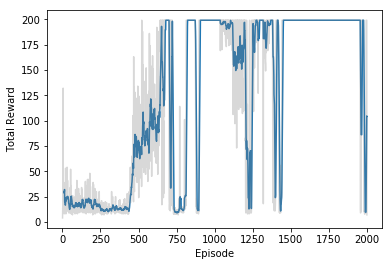

In [10]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
import time

saver = tf.train.Saver()
test_episodes = 10
test_max_steps = 600
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            
            env.render()
            time.sleep(0.05)
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, state.shape[0]))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


[2017-06-15 14:17:42,189] Restoring parameters from checkpoints/cartpole.ckpt


In [15]:
env.reset()
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.